## Import everything


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import itertools

import numpy as np
import time
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from matplotlib import cm 

import torch
import torch.optim as optim
from torch import nn

from spaces import FinitePowerSeries, FiniteChebyshev, GRF
from system import LTSystem, ODESystem, DRSystem, CVCSystem, ADVDSystem

from scipy.fft import fft, ifft, fftfreq
from scipy.linalg import dft
import scipy
from utils import merge_values, trim_to_65535, mean_squared_error_outlier, safe_test
from plot_utils import plot_schrodinger_3d, plot_schrodinger_prob
import wave_system_single

#from schrodinger_system import gen_schro_dataset_fixed, gen_schro_dataset_sigma, gen_schro_dataset_x0, gen_schro_dataset_fixed_real
#from models import model, model_matrix_batch




def model_matrix_batch(X, net, c, x_max): # take in num_datax1
    x_func = net.branch(torch.tensor(X[0])) # output num_datax 2x2, num_datax 4
    
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1])))

    x_func = x_func.view(x_func.shape[0], 2, -1).to(torch.float64)
    x_loc = x_loc.unsqueeze(2).to(torch.float64)
    
    #b =  torch.tensor([net.b[0], net.b[1]], dtype=torch.float64).unsqueeze(1)
    #b_batch = b.expand(x_func.shape[0], -1, -1).to(torch.float64)
    
    result = torch.bmm(x_func, x_loc).to(torch.float64) #+ b_batch
    #print(f"result: {result.shape}")
    return result.squeeze()

def model_wave(X, net, c, x_max):
    """Original DeepONet model for wave equation.

    Args:
        X (_type_): _description_
        net (_type_): _description_
        c (_type_): _description_
        x_max (_type_): _description_

    Returns:
        _type_: _description_
    """
    x_func = torch.tensor(X[0], dtype=torch.complex128)
    x_func = net.branch(x_func).to(torch.complex128) 
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1))).to(torch.complex128).squeeze(0)
    x_loc = x_loc.unsqueeze(-1)
    
    x_func = x_func.view(x_func.shape[0], np.shape(X[0])[1], -1).to(torch.complex128)
    #x_loc = x_loc.view(x_loc.shape[0], -1, 2).to(torch.complex128)
    
    result = torch.bmm(x_func, x_loc).to(torch.complex128) 
    #result  = torch.einsum('bij,kj->bik', x_func, x_loc)
    #result = torch.einsum('bi, bi->b', x_func, x_loc).to(torch.complex128)
    #result = net.concatenate_outputs(xs)
    #print(f"result = {result}")
    return result

def model_wave_small(X, net, c, x_max):

    x_func = torch.tensor(X[0], dtype=torch.complex128).unsqueeze(-1)
    x_func = net.branch(x_func).to(torch.complex128) 
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1))).to(torch.complex128).squeeze(0)
    x_loc = x_loc.unsqueeze(-1)
    
    #x_func = x_func.view(x_func.shape[0], np.shape(X[0])[1], -1).to(torch.complex128)
    #x_loc = x_loc.view(x_loc.shape[0], -1, 2).to(torch.complex128)
    
    result = torch.bmm(x_func, x_loc).to(torch.complex128) 
    #result  = torch.einsum('bij,kj->bik', x_func, x_loc)
    #result = torch.einsum('bi, bi->b', x_func, x_loc).to(torch.complex128)
    #result = net.concatenate_outputs(xs)
    #print(f"result = {result}")
    return result

def model_wave_multi(X, net, c, x_max ):
    x_func = torch.tensor(X[0], dtype=torch.complex128)
    x_func = net.branch(x_func).to(torch.complex128) 
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1))).to(torch.complex128).squeeze(0)
    #x_loc = x_loc.unsqueeze(-1)
    
    x_func = x_func.view(x_func.shape[0], np.shape(X[0])[1], -1).to(torch.complex128)
    x_loc = torch.transpose(x_loc, 0, 1)
    
    result = torch.matmul(x_func, x_loc).to(torch.complex128) 
    #result  = torch.einsum('bij,kj->bik', x_func, x_loc)
    #result = torch.einsum('bi, bi->b', x_func, x_loc).to(torch.complex128)
    #result = net.concatenate_outputs(xs)
    #print(f"result = {result}")
    return result.permute(0, 2, 1).squeeze()

def model_wave_energy_simple(X, net, c, x_max , fourier =True):
    """ DeepoNet model for wave equation with energy preservation.

    Args:
        X (_type_): _description_
        net (_type_): _description_
        c (_type_): _description_
        x_max (_type_): _description_
        fourier (bool, optional): _description_. Defaults to True.

    Returns:
        _type_: _description_
    """
    # Apply branch and trunk network
    x_func = torch.tensor(X[0], dtype=torch.complex128)
    x_func = net.branch(x_func).to(torch.complex128) 
    
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1))).to(torch.complex128).squeeze(0)
    x_loc = x_loc.unsqueeze(-1)
    
    x_func = x_func.view(x_func.shape[0], np.shape(X[0])[1], -1).to(torch.complex128)
    
    # Energy preservation on
    nx = int(X[0].shape[1] / 2)
    dx = x_max / (nx - 1)
    
    # DFT matrix W
    W_np = dft(nx)
    W = torch.tensor(W_np, dtype=torch.complex128)
    W_inv_np = W_np.conj().T / nx
    W_inv = torch.tensor(W_inv_np, dtype=torch.complex128).contiguous()
    
    W_large = torch.kron(torch.eye(2, dtype=torch.complex128), W)
    W_large_inv = torch.kron(torch.eye(2, dtype=torch.complex128), W_inv)
    
    # Differentiation matrix D
    k_np = (2 * np.pi ) * fftfreq(nx, dx)
    k = torch.tensor(k_np, dtype=torch.complex128)
    D = torch.diag(1j * k)
    D_large = torch.block_diag(D, torch.eye(nx, dtype=torch.complex128))
    D_large_sqrt = torch.block_diag(torch.diag(torch.abs(k)), torch.eye(nx, dtype=torch.complex128))
    
    # Define relvant matrices
    #omega = torch.block_diag(c**2*torch.eye(nx, dtype=torch.complex128), torch.eye(nx, dtype=torch.complex128))
    omega_sqrt = torch.block_diag(c*torch.eye(nx, dtype=torch.complex128), torch.eye(nx, dtype=torch.complex128))
    
    
    #theta = D_large.conj().T@W_large_inv.conj().T@omega@W_large_inv@D_large
    #theta = omega@D_large.conj().T@D_large / nx
    theta_sqrt = omega_sqrt@D_large_sqrt /torch.sqrt(torch.tensor(nx,dtype=torch.complex128))
    #c_tensor = torch.tensor(c, dtype=torch.complex128)
    
    #init = torch.tensor(X[0], dtype=torch.complex128)
    init_ux_sol = torch.tensor(X[0], dtype=torch.complex128)@D_large.conj().T@W_large_inv.conj().T
    #E_alt = init@theta@init.conj().T
  
    # Caulate energy
    E = (
    torch.sum(c**2 * (torch.abs(init_ux_sol[:, :nx])**2), dim=1) +
    torch.sum(torch.abs(init_ux_sol[:, nx:])**2, dim=1)).to(torch.complex128)
    

    # Decompose Q
    #theta_sqrt_batch = theta_sqrt.expand(x_func.shape[0], -1, -1)
    #theta_small = theta[1:, 1:]
    theta_small_sqrt = theta_sqrt[1:, 1:]
    theta_small_sqrt_inv = torch.diag(1 / torch.diagonal(theta_small_sqrt))
    
    b1s = x_func[:, 0, :]
    B_small = x_func[:, 1:, :]
    B_small_tilde = torch.einsum("pn, mnl ->mpl", theta_small_sqrt, B_small)
    
    
    Q_small_tilde, R = torch.linalg.qr(B_small_tilde)
    R_inv = torch.linalg.inv(R)
    
    
    
    Q_tilde = torch.zeros_like(x_func)
    
    # The first rows of each matrix
    Q_tilde[:, 0, :] = torch.matmul(b1s.unsqueeze(1), R_inv).squeeze(1)
    Q_tilde[:, 1:, :] = torch.einsum("pn, mnl -> mpl", theta_small_sqrt_inv, Q_small_tilde)
    
    
    alpha_tilde = torch.matmul(R, x_loc).to(torch.complex128)
    
    norm_alpha_tilde = torch.linalg.vector_norm(alpha_tilde, dim=1, keepdim=True)
    # Create a mask for zero values
    zero_mask = (norm_alpha_tilde == 0)

    # Replace zeros with ones in the denominator to avoid division by zero
    safe_norm = torch.where(zero_mask, torch.ones_like(norm_alpha_tilde), norm_alpha_tilde)
    #alpha_scaled = alpha_tilde* np.sqrt(E) / norm_alpha_tilde
    p = alpha_tilde.shape[1]
    alpha_scaled = alpha_tilde* torch.sqrt(E).unsqueeze(1).unsqueeze(2) / safe_norm
    
    result_energy = torch.bmm(Q_tilde, alpha_scaled).to(torch.complex128)
    
    
    return result_energy.squeeze()

def model_wave_energy_multi(X, net, c, x_max = 10, fourier =True):
    """ DeepoNet model for wave equation with energy preservation.

    Args:
        X (_type_): _description_
        net (_type_): _description_
        c (_type_): _description_
        x_max (_type_): _description_
        fourier (bool, optional): _description_. Defaults to True.

    Returns:
        _type_: _description_
    """
    # Apply branch and trunk network
    x_func = torch.tensor(X[0], dtype=torch.complex128)
    x_func = net.branch(x_func).to(torch.complex128) 
    
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1))).to(torch.complex128).squeeze(0)
    x_loc = x_loc.unsqueeze(-1)
    
    x_func = x_func.view(x_func.shape[0], np.shape(X[0])[1], -1).to(torch.complex128)
    
    # Energy preservation on
    nx = int(X[0].shape[1] / 2)
    dx = x_max / (nx - 1)
    
    # DFT matrix W
    W_np = dft(nx)
    W = torch.tensor(W_np, dtype=torch.complex128)
    W_inv_np = W_np.conj().T / nx
    W_inv = torch.tensor(W_inv_np, dtype=torch.complex128).contiguous()
    
    #W_large = torch.kron(torch.eye(2, dtype=torch.complex128), W)
    W_large_inv = torch.kron(torch.eye(2, dtype=torch.complex128), W_inv)
    
    # Differentiation matrix D
    k_np = (2 * np.pi ) * fftfreq(nx, dx)
    k = torch.tensor(k_np, dtype=torch.complex128)
    D = torch.diag(1j * k)
    D_large = torch.block_diag(D, torch.eye(nx, dtype=torch.complex128))
    D_large_sqrt = torch.block_diag(torch.diag(torch.abs(k)), torch.eye(nx, dtype=torch.complex128))
    
    # Define relvant matrices
    #omega = torch.block_diag(c**2*torch.eye(nx, dtype=torch.complex128), torch.eye(nx, dtype=torch.complex128))
    omega_sqrt = torch.block_diag(c*torch.eye(nx, dtype=torch.complex128), torch.eye(nx, dtype=torch.complex128))
    
    
    #theta = D_large.conj().T@W_large_inv.conj().T@omega@W_large_inv@D_large
    #theta = omega@D_large.conj().T@D_large / nx
    theta_sqrt = omega_sqrt@D_large_sqrt /torch.sqrt(torch.tensor(nx,dtype=torch.complex128))
    #c_tensor = torch.tensor(c, dtype=torch.complex128)
    
    #init = torch.tensor(X[0], dtype=torch.complex128)
    init_ux_sol = torch.tensor(X[0], dtype=torch.complex128)@D_large.conj().T@W_large_inv.conj().T
    #E_alt = init@theta@init.conj().T
  
    # Caulate energy
    E = (
    torch.sum(c**2 * (torch.abs(init_ux_sol[:, :nx])**2), dim=1) +
    torch.sum(torch.abs(init_ux_sol[:, nx:])**2, dim=1)).to(torch.complex128)
    

    # Decompose Q
    #theta_sqrt_batch = theta_sqrt.expand(x_func.shape[0], -1, -1)
    #theta_small = theta[1:, 1:]
    theta_small_sqrt = theta_sqrt[1:, 1:]
    theta_small_sqrt_inv = torch.diag(1 / torch.diagonal(theta_small_sqrt))
    
    b1s = x_func[:, 0, :]
    B_small = x_func[:, 1:, :]
    B_small_tilde = torch.einsum("pn, mnl ->mpl", theta_small_sqrt, B_small)
    
    
    Q_small_tilde, R = torch.linalg.qr(B_small_tilde)
    R_inv = torch.linalg.inv(R)
    
    
    
    Q_tilde = torch.zeros_like(x_func)
    
    # The first rows of each matrix
    Q_tilde[:, 0, :] = torch.matmul(b1s.unsqueeze(1), R_inv).squeeze(1)
    Q_tilde[:, 1:, :] = torch.einsum("pn, mnl -> mpl", theta_small_sqrt_inv, Q_small_tilde)
    
    
    alpha_tilde = torch.matmul(R, x_loc.permute(1, 0, 2).squeeze()).to(torch.complex128)
    
    norm_alpha_tilde = torch.linalg.vector_norm(alpha_tilde, dim=1, keepdim=True)
    # Create a mask for zero values
    zero_mask = (norm_alpha_tilde == 0)

    # Replace zeros with ones in the denominator to avoid division by zero
    safe_norm = torch.where(zero_mask, torch.ones_like(norm_alpha_tilde), norm_alpha_tilde)
    #alpha_scaled = alpha_tilde* np.sqrt(E) / norm_alpha_tilde
    p = alpha_tilde.shape[1]
    alpha_scaled = alpha_tilde* torch.sqrt(E).unsqueeze(1).unsqueeze(2) / safe_norm
    
    result_energy = torch.bmm(Q_tilde, alpha_scaled).to(torch.complex128)
    
    
    return result_energy.permute(0, 2, 1).squeeze()


def complex_relu(x):
    return torch.relu(x.real) + 1j * torch.relu(x.imag)

def complex_tanh(x):
    return torch.tanh(x.real) + 1j* torch.tanh(x.imag)

def complex_mse_loss(pred, target):
    """
    Compute the MSE loss for complex-valued tensors.
    
    Parameters:
        pred (torch.Tensor): Predicted complex tensor (dtype=torch.complex128 or torch.complex128)
        target (torch.Tensor): Target complex tensor (same shape and dtype as pred)

    Returns:
        torch.Tensor: Scalar tensor (the mean squared error)
    """
    pred_real = pred.real
    pred_imag = pred.imag
    target_real = target.real
    target_imag = target.imag
    
    mse_real = torch.mean((pred_real - target_real)**2)
    mse_imag = torch.mean((pred_imag - target_imag)**2)

    # Total loss is sum of both parts
    return mse_real + mse_imag

def complex_l2_relative_error(pred, target, std=False):
    """
    Compute the L2 relative error for complex-valued tensors.

    Parameters:
        pred (torch.Tensor): Predicted complex tensor (dtype=torch.complex64 or torch.complex128)
        target (torch.Tensor): Target complex tensor (same shape and dtype as pred)

    Returns:
        torch.Tensor: Scalar tensor (the relative error)
    """
    # Compute squared magnitude difference
    num_samples = pred.shape[0]
    error = pred - target
    l2_err = torch.zeros(num_samples, dtype=torch.float64, device=target.device)
    for i in range(num_samples):
        
        error_norm = torch.sum(error[i].real**2 + error[i].imag**2)
        # Compute squared magnitude of target
        target_norm = torch.sum(target[i].real**2 + target[i].imag**2)
        # Avoid divide-by-zero (in case the target is all zeros, though this is rare)
        if target_norm == 0:
            return torch.tensor(float('inf'), device=target.device)
        # Relative L2 error
        rel_error = torch.sqrt(error_norm / target_norm)
        l2_err[i] = rel_error
    
    if std:
        return torch.mean(l2_err), torch.std(l2_err)

    return torch.mean(l2_err)

def wave_energy_loss(y_pred, y_true,std=False):
    """
    Compute the MSE loss for complex-valued tensors.
    
    Parameters:
        pred (torch.Tensor): Predicted complex tensor (dtype=torch.complex128 or torch.complex128)
        target (torch.Tensor): Target complex tensor (same shape and dtype as pred)

    Returns:
        torch.Tensor: Scalar tensor (the mean squared error)
    """
    global L, c
    nx = int(y_pred.shape[-1] / 2)
    dx = L / (nx - 1)
    
    # DFT matrix W
    W_np = dft(nx)
    W = torch.tensor(W_np, dtype=torch.complex128)
    W_inv_np = W_np.conj().T / nx
    W_inv = torch.tensor(W_inv_np, dtype=torch.complex128).contiguous()
    
    #W_large = torch.kron(torch.eye(2, dtype=torch.complex128), W)
    W_large_inv = torch.kron(torch.eye(2, dtype=torch.complex128), W_inv)
    
    # Differentiation matrix D
    k_np = (2 * np.pi ) * fftfreq(nx, dx)
    k = torch.tensor(k_np, dtype=torch.complex128)
    D = torch.diag(1j * k)
    D_large = torch.block_diag(D, torch.eye(nx, dtype=torch.complex128))
    
    
    y_pred_x_sol = y_pred@D_large.T@W_large_inv.T
    y_true_x_sol = y_true@D_large.T@W_large_inv.T
    
    energy_pred = dx*(torch.sum(c**2*torch.abs(y_pred_x_sol[:,:, 0: nx])**2,dim=-1) + torch.sum(torch.abs(y_pred_x_sol[:, :, nx:])**2, dim=-1)).to(torch.complex128)
    energy_true = dx*(torch.sum(c**2*torch.abs(y_true_x_sol[:,:, 0: nx])**2,dim=-1) + torch.sum(torch.abs(y_true_x_sol[:,:, nx:])**2, dim=-1)).to(torch.complex128)
    
    energy_err = torch.abs(energy_pred - energy_true)**2
    
    if std:
        return torch.mean(energy_err), torch.std(energy_err)

    return torch.mean(energy_err)


def wave_mse_energy_loss(y_pred, y_true):
    return complex_mse_loss(y_pred, y_true) + wave_energy_loss(y_pred, y_true)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Generate datasets

In [43]:
# Load dataset

num_train = 500
num_test = 100
#num_train = 800
#num_test= 200
#epochs = 1
#epochs = 500
#epochs = 50000
epochs = 10000
nt = 50




nx = 20
# Domain 
L = 10
T = 1
c = 1.2
p = nx
#X_train, y_train = wave_system_single.gen_wave_fourier_rand_fixed_speed(num = num_train, Nx = nx, x_max= L, tf=T)
#X_test, y_test = wave_system_single.gen_wave_fourier_rand_fixed_speed(num=num_test, Nx = nx, x_max = L, tf = T)

X_train, y_train = wave_system_single.gen_wave_fourier_rand_GRF_fixed_speed_multi(Nu = num_train, Nx = nx,Nt = nt, x_max= L, tf=T, c= c)
X_test, y_test = wave_system_single.gen_wave_fourier_rand_GRF_fixed_speed_multi(Nu=num_test, Nx = nx, Nt=nt, x_max = L, tf = T, c= c)
#data = dde.data.TripleCartesianProd(X_train, y_train, X_test, y_test)
print(f"x_train : {np.shape(X_train[0])}, {np.shape(X_train[1])} \n y_train: {np.shape(y_train)}")


x_train : (500, 40), (50,) 
 y_train: (500, 50, 40)


## Load models

In [4]:


wave_multi_net = dde.nn.DeepONetComplex(
    [2*nx, 2*nx*p, 2*nx*p], [1, p, p, p], complex_relu, "Glorot normal"
)  

wave_energy_multi_net = dde.nn.DeepONetComplex(
    [2*nx, 2*nx*p, 2*nx*p], [1, p, p, p], complex_relu, "Glorot normal"
)

wave_SL_multi_net = dde.nn.DeepONetComplex(
    [2*nx, 2*nx*p, 2*nx*p], [1, p, p, p], complex_relu, "Glorot normal"
)


In [6]:
import os
os.getcwd()

'c:\\Users\\zzh\\Desktop\\Oxford\\dissertation\\deeponet\\src'

In [5]:
%cd C:\Users\zzh\Desktop\Oxford\dissertation\deeponet

C:\Users\zzh\Desktop\Oxford\dissertation\deeponet


c:\Users\zzh\Desktop\Oxford\dissertation\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
checkpoint_multi = torch.load("trained_nets/model_wave_multi_epoch10000_net-800-20_loss-complex_mse_loss.pt", map_location=torch.device('cpu'))
checkpoint_energy_multi = torch.load("trained_nets/model_wave_energy_multi_epoch10000_net-800-20_loss-complex_mse_loss.pt", map_location=torch.device('cpu'))
checkpoint_SL_multi = torch.load("trained_nets/model_wave_multi_epoch10000_net-800-20_loss-wave_mse_energy_loss.pt", map_location=torch.device('cpu'))

wave_multi_net.load_state_dict(checkpoint_multi['model_state_dict'])
wave_energy_multi_net.load_state_dict(checkpoint_energy_multi['model_state_dict'])
wave_SL_multi_net.load_state_dict(checkpoint_SL_multi['model_state_dict'])


C:\Users\zzh\AppData\Local\Temp\ipykernel_12988\3506858443.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_multi = torch.load("trained_nets/model_wave_multi_e

<All keys matched successfully>

## Inference

In [44]:

with torch.no_grad():
    print(c)
    y_train_pred_multi = model_wave_multi(X_train, wave_multi_net, c, L)
    y_train_pred_energy = model_wave_energy_multi(X_train, wave_energy_multi_net, c, L)
    y_train_multi_pred_energy = model_wave_energy_multi(X_train, wave_multi_net, c, L)
    y_train_pred_SL = model_wave_multi(X_train, wave_SL_multi_net, c, L)
    #y_pred_multi = model_wave_multi(X_test, wave_multi_net, c, L)

1.2


In [45]:
print(f"Vanilla:")
l2_err, l2_std = complex_l2_relative_error(y_train_pred_multi.squeeze(), torch.tensor(y_train, dtype=torch.complex128), std=True)
energy_mse, energy_std = wave_energy_loss(y_train_pred_multi.squeeze(), torch.tensor(y_train, dtype=torch.complex128), std=True)
print(f"Final L2 error: {l2_err:.6f} +- {l2_std:.6f}")
print(f"Final energy error: {energy_mse:.6f} +- {energy_std:.6f}")
print("------------------------------------------------------------\n")


print(f"Energy layer:")
l2_err, l2_std = complex_l2_relative_error(y_train_pred_energy.squeeze(), torch.tensor(y_train, dtype=torch.complex128), std=True)
energy_mse, energy_std = wave_energy_loss(y_train_pred_energy.squeeze(), torch.tensor(y_train, dtype=torch.complex128), std=True)
print(f"Final L2 error: {l2_err:.6f} +- {l2_std:.6f}")
print(f"Final energy error: {energy_mse:.6f} +- {energy_std:.6f}")
print("------------------------------------------------------------\n")

print(f"Trained multi test with Energy layer:")
l2_err, l2_std = complex_l2_relative_error(y_train_multi_pred_energy.squeeze(), torch.tensor(y_train, dtype=torch.complex128), std=True)
energy_mse, energy_std = wave_energy_loss(y_train_multi_pred_energy.squeeze(), torch.tensor(y_train, dtype=torch.complex128), std=True)
print(f"Final L2 error: {l2_err:.6f} +- {l2_std:.6f}")
print(f"Final energy error: {energy_mse:.6f} +- {energy_std:.6f}")
print("------------------------------------------------------------\n")



print(f"Energy loss:")
l2_err, l2_std = complex_l2_relative_error(y_train_pred_SL.squeeze(), torch.tensor(y_train, dtype=torch.complex128), std=True)
energy_mse, energy_std = wave_energy_loss(y_train_pred_SL.squeeze(), torch.tensor(y_train, dtype=torch.complex128), std=True)
print(f"Final L2 error: {l2_err:.6f} +- {l2_std:.6f}")
print(f"Final energy error: {energy_mse:.6f} +- {energy_std:.6f}")
print("------------------------------------------------------------\n")

Vanilla:
Final L2 error: 0.479977 +- 0.046472
Final energy error: 179.854454 +- 371.850978
------------------------------------------------------------

Energy layer:
Final L2 error: 0.485807 +- 0.052188
Final energy error: 0.000000 +- 0.000000
------------------------------------------------------------

Trained multi test with Energy layer:
Final L2 error: 0.485077 +- 0.052576
Final energy error: 0.000000 +- 0.000000
------------------------------------------------------------

Energy loss:
Final L2 error: 0.487168 +- 0.048504
Final energy error: 176.410979 +- 365.797117
------------------------------------------------------------



In [26]:
wave_multi_train_err = checkpoint_multi['train_errors']
wave_multi_test_err = checkpoint_multi['test_errors']
wave_energy_train_err = checkpoint_energy_multi['train_errors']
wave_energy_test_err = checkpoint_energy_multi['test_errors']
wave_SL_train_err = checkpoint_SL_multi['train_errors']
wave_SL_test_err = checkpoint_SL_multi['test_errors']

## Convergence

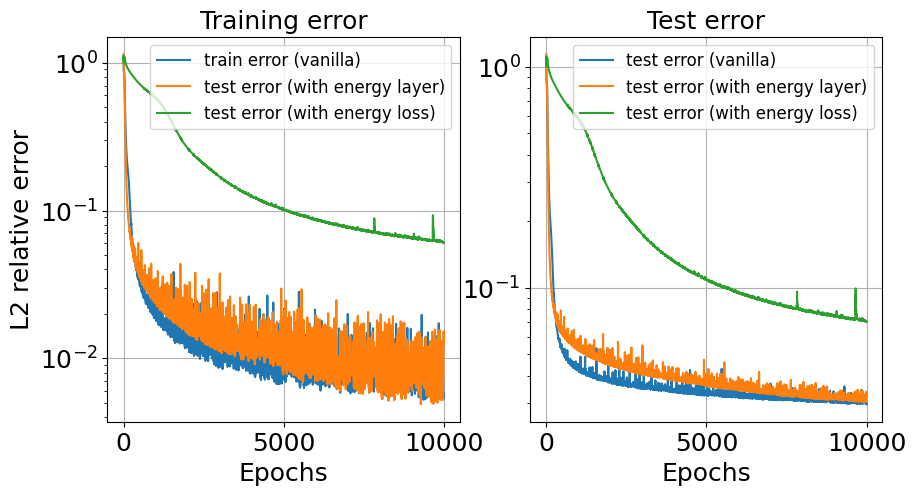

In [10]:
fontsize = 18
plt.rcParams.update({'font.size': fontsize})
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(10,5))
ax1.plot(wave_multi_train_err, label = "train error (vanilla)")
ax1.plot(wave_energy_train_err, label = "test error (with energy layer)")
ax1.plot(wave_SL_train_err, label = "test error (with energy loss)")
ax1.set_yscale('log')
ax1.set_xlabel("Epochs",fontsize=fontsize)
ax1.grid(True)
ax1.legend(prop={'size': 12})
ax1.set_title("Training error", fontsize=fontsize)
ax1.set_ylabel("L2 relative error", fontsize=fontsize)

ax2.plot(wave_multi_test_err, label = "test error (vanilla)")
ax2.plot(wave_energy_test_err, label = "test error (with energy layer)")
ax2.plot(wave_SL_test_err, label = "test error (with energy loss)")
ax2.set_yscale('log')
ax2.set_title("Test error" ,fontsize=fontsize)
ax2.grid(True)  
ax2.set_xlabel('Epochs', fontsize=fontsize)
#ax2.set_ylabel('L2 relative error', fontsize=fontsize)
ax2.legend(prop={'size': 12})

## 3D

c:\Users\zzh\Desktop\Oxford\dissertation\.venv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


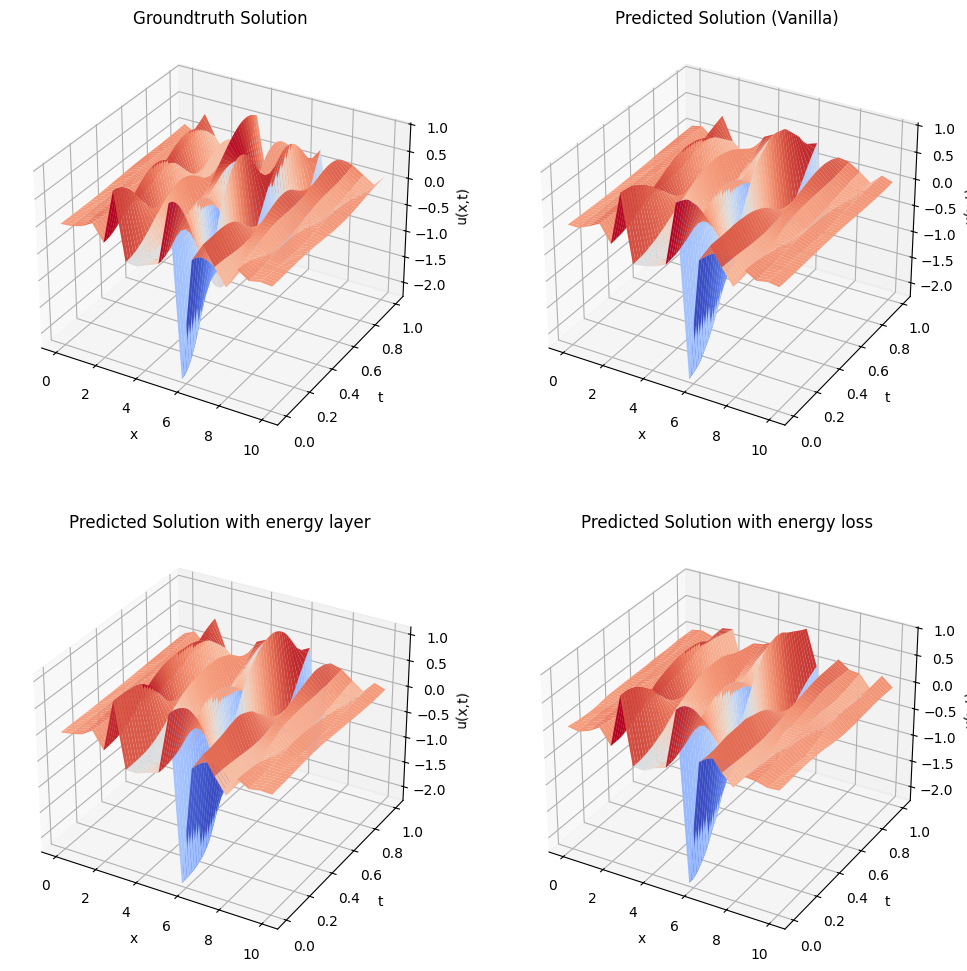

In [ ]:




fig, axes = plt.subplots(2, 2, subplot_kw={'projection': '3d'},figsize=(12, 12))



# Plot predicted solution
axes[0,0].plot_surface(x_grid, t_grid, y_train_sol[i, :, 0 : nx], rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
axes[0,0].set_title("Groundtruth Solution")
axes[0,0].set_xlabel("x")
axes[0,0].set_ylabel("t")
axes[0,0].set_zlabel("u(x,t)")


axes[0,1].plot_surface(x_grid, t_grid, y_train_pred_multi_sol[i,:, 0: nx], rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
axes[0,1].set_title("Predicted Solution (Vanilla)")
axes[0,1].set_xlabel("x")
axes[0,1].set_ylabel("t")
axes[0,1].set_zlabel("u(x,t)")

axes[1, 0].plot_surface(x_grid, t_grid, y_train_pred_energy_sol[i,:, 0: nx], rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
axes[1, 0].set_title("Predicted Solution with energy layer")
axes[1, 0].set_xlabel("x")
axes[1, 0].set_ylabel("t")
axes[1, 0].set_zlabel("u(x,t)")

axes[1, 1].plot_surface(x_grid, t_grid, y_train_pred_SL_sol[i,:, 0: nx], rstride=1, cstride=1,cmap = cm.coolwarm, edgecolor="none")
axes[1, 1].set_title("Predicted Solution with energy loss")
axes[1, 1].set_xlabel("x")
axes[1, 1].set_ylabel("t")
axes[1, 1].set_zlabel("u(x,t)")
plt.show()

## 2D and energy

In [40]:
i = 50

#y_true = y_test[i]

# Plot 
x = np.linspace(0, L, nx)
t = np.linspace(0, T, nt)   
x_grid, t_grid  = np.meshgrid(x, t)

W = dft(nx)
W_inv = W.conj().T / nx


#W_large = np.kron(np.eye(2), W)
W_large_inv = np.kron(np.eye(2), W_inv)
#print(f"W inv{W_large_inv.shape}")
#print(f"y_pred {y_pred.shape}")
y_train_sol = y_train@W_large_inv.T
y_train_pred_multi_sol = y_train_pred_multi.numpy()@W_large_inv.T
y_train_pred_SL_sol = y_train_pred_SL.numpy()@W_large_inv.T
y_train_pred_energy_sol = y_train_pred_energy.numpy()@W_large_inv.T

L = 10, T = 1, c= 0.8


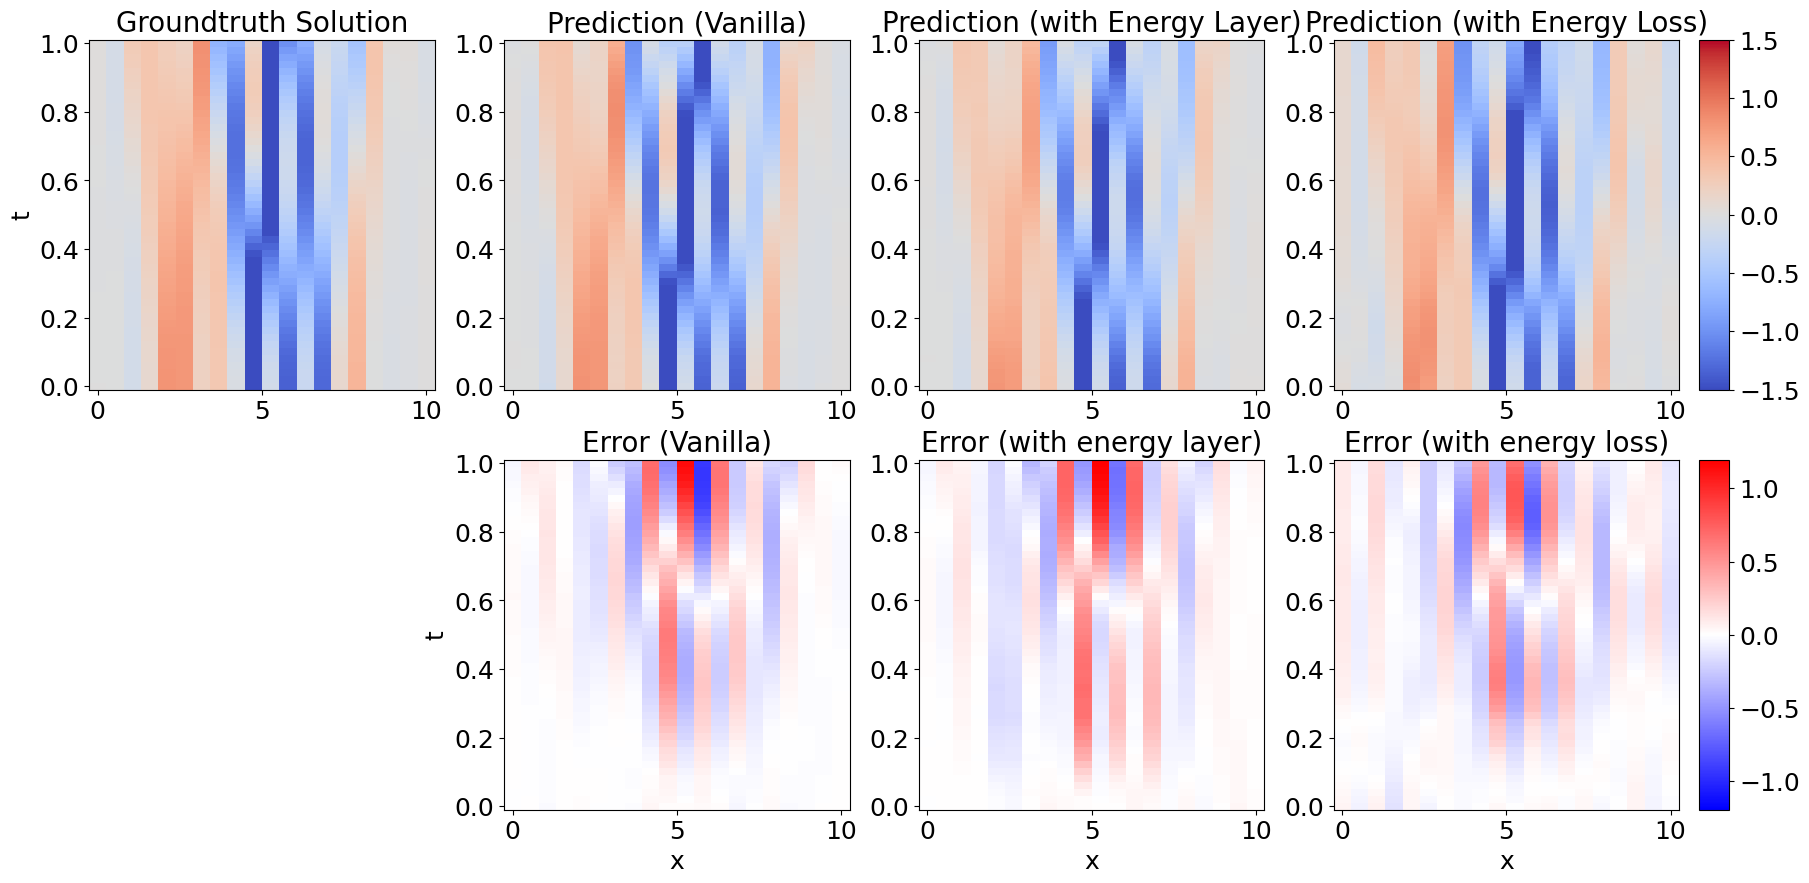

In [41]:
fontsize = 20
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
max_sol = np.max(y_train_sol[:, 0:nx].real)


min_sol= np.min(y_train_sol[:, 0:nx].real)

pcm0 = axes[0, 0].pcolormesh(x_grid, t_grid, y_train_sol[i, :, 0:nx].real, shading='auto', cmap= cm.coolwarm, vmin= -1.5, vmax=1.5)
axes[0, 0].set_title("Groundtruth Solution", fontsize=fontsize)
#axes[0, 0].set_xlabel("x", fontsize=fontsize)
axes[0, 0].set_ylabel("t")

pcm1 = axes[0, 1].pcolormesh(x_grid, t_grid, y_train_pred_multi_sol[i, :, 0:nx].real, shading='auto', cmap= cm.coolwarm,vmin=-1.5, vmax= 1.5)
axes[0, 1].set_title("Prediction (Vanilla)", fontsize=fontsize)
#axes[0, 1].set_xlabel("x", fontsize=fontsize)
#axes[0, 1].set_ylabel("t")
 # optional: shows the color scale

pcm2 = axes[0, 2].pcolormesh(x_grid, t_grid, y_train_pred_energy_sol[i, :, 0:nx].real, shading='auto', cmap= cm.coolwarm, vmin= -1.5, vmax=1.5)
axes[0, 2].set_title("Prediction (with Energy Layer)", fontsize=fontsize)
#axes[0, 2].set_xlabel("x", fontsize=fontsize)
#axes[0, 2].set_ylabel("t")

pcm3 = axes[0, 3].pcolormesh(x_grid, t_grid, y_train_pred_SL_sol[i, :, 0:nx].real, shading='auto', cmap= cm.coolwarm, vmin= - 1.5, vmax= 1.5)
axes[0, 3].set_title("Prediction (with Energy Loss)", fontsize=fontsize)
#axes[0, 3].set_xlabel("x", fontsize=fontsize)
#axes[0, 3].set_ylabel("t")

#fig.colorbar(pcm1, ax=axes[0, 0])
#fig.colorbar(pcm1, ax=axes[0, 1])
#fig.colorbar(pcm1, ax=axes[0, 2])
#fig.colorbar(pcm1, ax=axes[0, 3])
top_row_axes = axes[0, :]

# Place a standalone colorbar axis to the right of the top row


# Adjust the figure to make room for colorbar
fig.subplots_adjust(right=0.92)  # squashes nothing, just reserves space

# Add colorbar axis: [left, bottom, width, height]
cbar_ax_top = fig.add_axes([0.93, 0.53, 0.015, 0.35])  # adjust if needed

# Attach shared colorbar using any of the top-row pcms
fig.colorbar(pcm0, cax=cbar_ax_top)
axes[1, 0].axis('off')

error_multi = y_train_pred_multi_sol[i,:, 0:nx].real - y_train_sol[i,:, 0:nx].real
error_energy = y_train_pred_energy_sol[i,:, 0:nx].real - y_train_sol[i,:, 0:nx].real
error_SL = y_train_pred_SL_sol[i,:, 0:nx].real - y_train_sol[i, :, 0:nx].real

absmax_err = max(
    np.max(np.abs(error_multi)),
    np.max(np.abs(error_energy)),
    np.max(np.abs(error_SL))
)

pcm4 = axes[1, 1].pcolormesh(x_grid, t_grid,error_multi, shading='auto', cmap= cm.bwr, vmin=-absmax_err, vmax = absmax_err)
axes[1, 1].set_title("Error (Vanilla)", fontsize=fontsize)
axes[1, 1].set_xlabel("x")
axes[1, 1].set_ylabel("t")

pcm5 = axes[1, 2].pcolormesh(x_grid, t_grid,error_energy, shading='auto', cmap= cm.bwr, vmin=-absmax_err, vmax = absmax_err)
axes[1, 2].set_title("Error (with energy layer)", fontsize=fontsize)
axes[1, 2].set_xlabel("x")
#axes[1, 2].set_ylabel("t")
#plt.savefig(f"C:\\Users\\zzh\\Desktop\\Oxford\\dissertation\\deeponet\\plots\\wave_pred_2d_{model.__name__}_net-{net.branch.linears[-1].out_features}-{net.trunk.linears[-1].out_features}_loss_fn-{loss_fn.__name__}_l2-{optimizer.param_groups[0]["weight_decay"]}")

pcm6 = axes[1, 3].pcolormesh(x_grid, t_grid,error_SL, shading='auto', cmap= cm.bwr, vmin=-absmax_err, vmax = absmax_err)
axes[1, 3].set_title("Error (with energy loss)", fontsize=fontsize)
axes[1, 3].set_xlabel("x")
#axes[1, 3].set_ylabel("t")


bottom_row_axes = axes[1, :]
cbar_ax_bottom = fig.add_axes([0.93, 0.11, 0.015, 0.35])  # adjust if needed

# Attach shared colorbar using any of the top-row pcms
fig.colorbar(pcm6, cax=cbar_ax_bottom)
print(f"L = {L}, T = {T}, c= {c}")

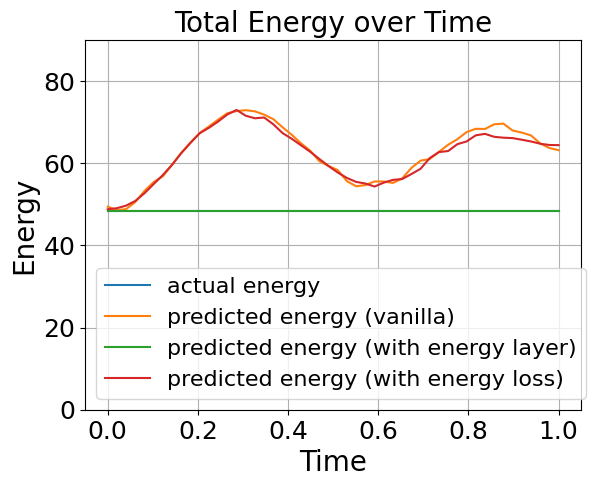

In [42]:
fontsize =20
dx = L / (nx - 1)
k = 2 * np.pi * fftfreq(nx, dx)

W = dft(nx)
W_inv = W.conj().T / nx

W_large = np.kron(np.eye(2), W)
W_large_inv = np.kron(np.eye(2), W_inv)
# Construct differentiation matrix
D = np.diag(1j * k)
D_large = np.block([[D, np.zeros((nx, nx))], [np.zeros((nx, nx)), np.eye(nx)]])


y_train_x_sol = y_train@D_large.T@W_large_inv.T
y_pred_x_sol_multi = y_train_pred_multi.numpy()@D_large.T@W_large_inv.T
y_pred_x_sol_energy = y_train_pred_energy.numpy()@D_large.T@W_large_inv.T
y_pred_x_sol_SL = y_train_pred_SL.numpy()@D_large.T@W_large_inv.T

fig = plt.figure()

t = np.linspace(0, T, nt)   


energy_pred_multi = dx*np.array([np.sum(c**2*np.abs(y[0: nx])**2) + np.sum(np.abs(y[nx :])**2) for y in y_pred_x_sol_multi[i]])
energy_pred_energy = dx*np.array([np.sum(c**2*np.abs(y[0: nx])**2) + np.sum(np.abs(y[nx :])**2) for y in y_pred_x_sol_energy[i]])
energy_pred_SL = dx*np.array([np.sum(c**2*np.abs(y[0: nx])**2) + np.sum(np.abs(y[nx :])**2) for y in y_pred_x_sol_SL[i]])
energy_true = dx*np.array([np.sum(c**2*np.abs(y_train_x_sol[i, 0,0:nx])**2) + np.sum(np.abs(y_train_x_sol[i, 0, nx:])**2)] *nt)
# Plot predicted solution
energy_max = max(np.max(np.abs(energy_true)), np.max(np.abs(energy_pred_multi)), np.max(np.abs(energy_pred_energy)), np.max(np.abs(energy_pred_SL)))


plt.plot(t, energy_true, label='actual energy')
plt.plot(t, energy_pred_multi, label='predicted energy (vanilla)')
plt.plot(t, energy_pred_energy, label='predicted energy (with energy layer)')
plt.plot(t, energy_pred_SL, label='predicted energy (with energy loss)')
plt.grid(True)
plt.xlabel("Time", fontsize=fontsize)
plt.ylim(0, (energy_max // 10)*10 + 20)
plt.ylabel("Energy", fontsize=fontsize)
plt.legend(prop = {'size': 16})
plt.title("Total Energy over Time", fontsize=fontsize)
#plt.savefig(f"C:\\Users\\zzh\\Desktop\\Oxford\\dissertation\\deeponet\\plots\\wave_energy_{model.__name__}_net-{net.branch.linears[-1].out_features}-{net.trunk.linears[-1].out_features}_loss-{loss_fn.__name__}_l2-{optimizer.param_groups[0]["weight_decay"]}")
plt.show()

In [92]:
c

1.5

In [71]:
energy_pred_energy

array([178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435, 178.46447435, 178.46447435,
       178.46447435, 178.46447435])